In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

In [11]:
#loading data
train = pd.read_csv('data/digit-recognizer/train.csv')
test = pd.read_csv('data/digit-recognizer/test.csv')

df = train.copy()
df_test = test.copy()

In [12]:
#Just having a look at the data
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [13]:
#check for any missing values in train data
df.isnull().any().sum()

0

In [14]:
#check for any missing values in test data
df_test.isnull().any().sum()

0

In [15]:
## Setting the seeds for Reproducibility.
seed = 3141
np.random.seed(seed)

In [16]:
# X is the pixels and Y is the image labels
X = train.iloc[:,1:]
Y = train.iloc[:,0]

#splitting dataframe using train_test_split
x_train , x_test , y_train , y_test = train_test_split(X, Y , test_size=0.1, random_state=seed)

In [17]:
#first param in reshape is number of examples. We can pass -1 here as we want numpy to figure that out by itself

#reshape(examples, height, width, channels)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
df_test=df_test.values.reshape(-1,28,28,1)

In [21]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

In [23]:
#convert values to float as result will be a float. If not done vals are set to zero

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

In [24]:
#fitting the ImageDataGenerator we defined above
datagen.fit(x_train)

In [25]:
#notice num_classes is set to 10 as we have 10 different labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
#Conv2d data_format parameter we use 'channel_last' for imgs

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [27]:
#Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

d:\112\program\matang\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [30]:
#for our case LearningRateScheduler will work great
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [31]:
#visualizing what the learning rate decay will do to the learning rate through every epoch
decays = [(lambda x: 1e-3 * 0.9 ** x)(x) for x in range(10)]
i=1

for lr in decays:
    print("Epoch " + str(i) +" Learning Rate: " + str(lr))
    i+=1

Epoch 1 Learning Rate: 0.001
Epoch 2 Learning Rate: 0.0009000000000000001
Epoch 3 Learning Rate: 0.0008100000000000001
Epoch 4 Learning Rate: 0.0007290000000000002
Epoch 5 Learning Rate: 0.0006561000000000001
Epoch 6 Learning Rate: 0.00059049
Epoch 7 Learning Rate: 0.000531441
Epoch 8 Learning Rate: 0.0004782969000000001
Epoch 9 Learning Rate: 0.0004304672100000001
Epoch 10 Learning Rate: 0.0003874204890000001


In [32]:
#by default this is evaluated on 'val_loss'
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [33]:
#defining these prior to model to increase readability and debugging
batch_size = 64
epochs = 50

In [34]:
# Fit the Model
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=1, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr]) #left out early_stopping parameter as it gets better accuracy

C:\Users\achru\AppData\Local\Temp\ipykernel_33772\4224154261.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs,


Epoch 1/50
590/590 [==============================] - 247s 413ms/step - loss: 0.3684 - accuracy: 0.8916 - val_loss: 0.1920 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 2/50
590/590 [==============================] - 243s 412ms/step - loss: 0.1265 - accuracy: 0.9600 - val_loss: 0.0613 - val_accuracy: 0.9800 - lr: 9.0000e-04
Epoch 3/50
590/590 [==============================] - 226s 383ms/step - loss: 0.0979 - accuracy: 0.9706 - val_loss: 0.0619 - val_accuracy: 0.9848 - lr: 8.1000e-04
Epoch 4/50
590/590 [==============================] - 226s 383ms/step - loss: 0.0795 - accuracy: 0.9754 - val_loss: 0.0329 - val_accuracy: 0.9912 - lr: 7.2900e-04
Epoch 5/50
590/590 [==============================] - 223s 378ms/step - loss: 0.0685 - accuracy: 0.9787 - val_loss: 0.0300 - val_accuracy: 0.9902 - lr: 6.5610e-04
Epoch 6/50
590/590 [==============================] - 237s 402ms/step - loss: 0.0650 - accuracy: 0.9802 - val_loss: 0.0247 - val_accuracy: 0.9907 - lr: 5.9049e-04
Epoch 7/50
590/590 [======

In [35]:
import matplotlib.pyplot as plt

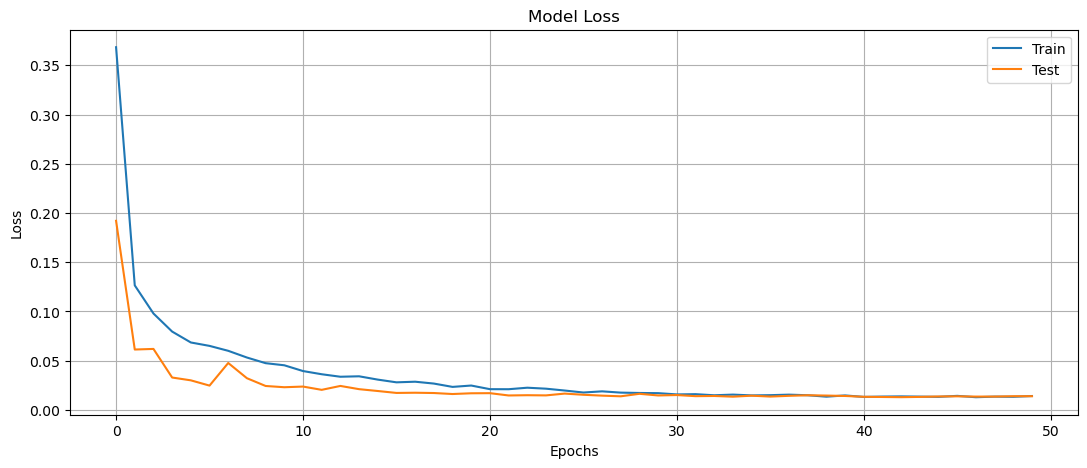

In [36]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

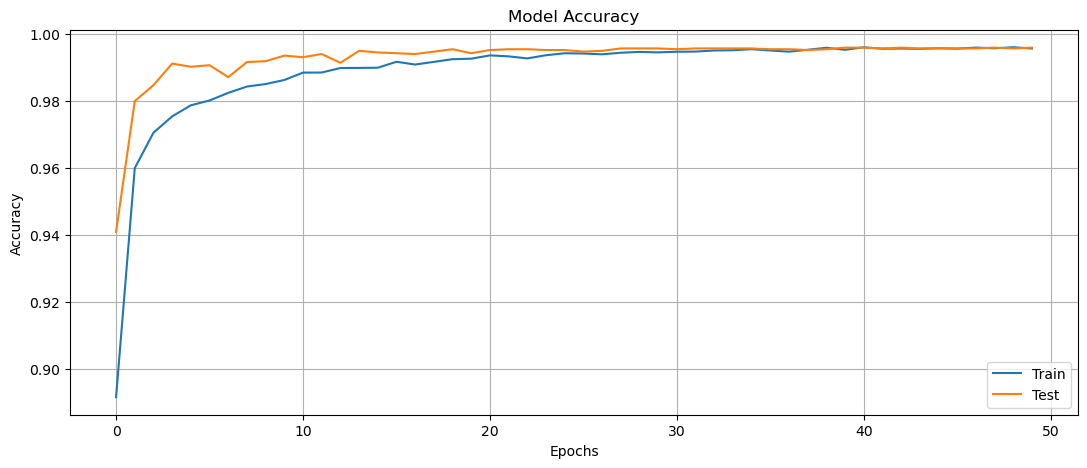

In [37]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

In [40]:
pred_digits_test = np.argmax(model.predict(df_test),axis=1)
image_id_test = []

for i in range (len(pred_digits_test)):
    image_id_test.append(i+1)
    
d = {'ImageId':image_id_test,'Label':pred_digits_test}
answer = pd.DataFrame(d)

answer.to_csv('answer.csv',index=False)

875/875 [==============================] - 10s 11ms/step
